In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('clean.csv')

In [3]:
data

,date,AQI,latitude,longitude
0,2023-04-01 00:00:00,45.765,27.889417,71.375264
1,2023-04-01 01:00:00,46.520,27.889417,71.375264
2,2023-04-01 02:00:00,47.640,27.889417,71.375264
3,2023-04-01 03:00:00,49.330,27.889417,71.375264
4,2023-04-01 04:00:00,51.210,27.889417,71.375264
...,...,...,...,...
9236,2024-04-19 20:00:00,64.075,27.889417,71.375264
9237,2024-04-19 21:00:00,64.950,27.889417,71.375264
9238,2024-04-19 22:00:00,63.735,27.889417,71.375264
9239,2024-04-19 23:00:00,61.845,27.889417,71.375264


In [4]:
data = data[['date', 'AQI']]
data

,date,AQI
0,2023-04-01 00:00:00,45.765
1,2023-04-01 01:00:00,46.520
2,2023-04-01 02:00:00,47.640
3,2023-04-01 03:00:00,49.330
4,2023-04-01 04:00:00,51.210
...,...,...
9236,2024-04-19 20:00:00,64.075
9237,2024-04-19 21:00:00,64.950
9238,2024-04-19 22:00:00,63.735
9239,2024-04-19 23:00:00,61.845


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\timmy\AppData\Local\Temp\ipykernel_24932\3395756933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


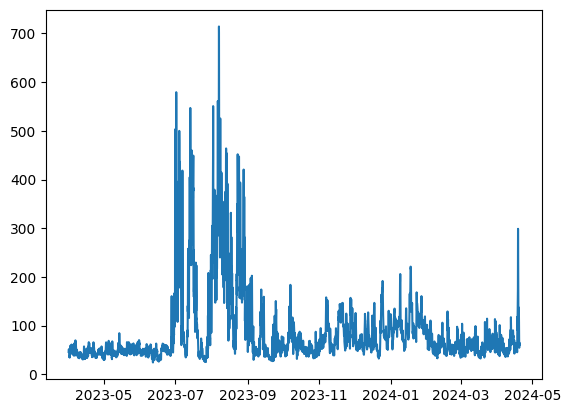

In [6]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['AQI'])

In [7]:
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_data(data, lookback)
shifted_df

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
date,,,,,,,,
2023-04-01 07:00:00,47.205,49.650,51.400,51.210,49.330,47.640,46.520,45.765
2023-04-01 08:00:00,44.425,47.205,49.650,51.400,51.210,49.330,47.640,46.520
2023-04-01 09:00:00,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640
2023-04-01 10:00:00,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330
2023-04-01 11:00:00,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210
...,...,...,...,...,...,...,...,...
2024-04-19 20:00:00,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880
2024-04-19 21:00:00,64.950,64.075,61.375,57.480,54.325,55.820,68.255,86.095
2024-04-19 22:00:00,63.735,64.950,64.075,61.375,57.480,54.325,55.820,68.255


In [8]:
# converting to an array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[47.205, 49.65 , 51.4  , ..., 47.64 , 46.52 , 45.765],
       [44.425, 47.205, 49.65 , ..., 49.33 , 47.64 , 46.52 ],
       [42.035, 44.425, 47.205, ..., 51.21 , 49.33 , 47.64 ],
       ...,
       [63.735, 64.95 , 64.075, ..., 54.325, 55.82 , 68.255],
       [61.845, 63.735, 64.95 , ..., 57.48 , 54.325, 55.82 ],
       [60.765, 61.845, 63.735, ..., 61.375, 57.48 , 54.325]])

In [10]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.51809868, -0.485499  , -0.46216203, ..., -0.51218743,
        -0.52708496, -0.53712404],
       [-0.55514309, -0.51807922, -0.48548106, ..., -0.48966847,
        -0.51216129, -0.52706397],
       [-0.58699062, -0.55512339, -0.51806108, ..., -0.4646178 ,
        -0.48964254, -0.51214041],
       ...,
       [-0.297831  , -0.28162283, -0.2932656 , ..., -0.42311096,
        -0.40316521, -0.23745376],
       [-0.32301587, -0.29781299, -0.28160609, ..., -0.38107113,
        -0.42308564, -0.40314518],
       [-0.33740722, -0.3229977 , -0.29779616, ..., -0.32917093,
        -0.3810462 , -0.42306546]])

In [11]:
# saving the scaler
import joblib

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9234, 7), (9234,))

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[-0.53712404, -0.52708496, -0.51218743, ..., -0.46467253,
        -0.46216203, -0.485499  ],
       [-0.52706397, -0.51216129, -0.48966847, ..., -0.46214077,
        -0.48548106, -0.51807922],
       [-0.51214041, -0.48964254, -0.4646178 , ..., -0.48545964,
        -0.51806108, -0.55512339],
       ...,
       [-0.23745376, -0.40316521, -0.42311096, ..., -0.3292232 ,
        -0.2932656 , -0.28162283],
       [-0.40314518, -0.42308564, -0.38107113, ..., -0.29324551,
        -0.28160609, -0.29781299],
       [-0.42306546, -0.3810462 , -0.32917093, ..., -0.28158607,
        -0.29779616, -0.3229977 ]])

In [15]:
split_index = int(len(X) * 0.99)

split_index

9141

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9141, 7), (93, 7), (9141,), (93,))

In [17]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9141, 7, 1), (93, 7, 1), (9141, 1), (93, 1))

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9141, 7, 1]),
 torch.Size([93, 7, 1]),
 torch.Size([9141, 1]),
 torch.Size([93, 1]))

In [19]:
# Creating a dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
train_dataset

In [21]:
# Data Loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [23]:
# LSTM Model


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out



In [24]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()

In [26]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [27]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.010
Batch 200, Loss: 0.657
Batch 300, Loss: 0.654
Batch 400, Loss: 0.444
Batch 500, Loss: 0.270

Val Loss: 0.185
***************************************************

Epoch: 2
Batch 100, Loss: 0.201
Batch 200, Loss: 0.154
Batch 300, Loss: 0.225
Batch 400, Loss: 0.218
Batch 500, Loss: 0.184

Val Loss: 0.137
***************************************************

Epoch: 3
Batch 100, Loss: 0.164
Batch 200, Loss: 0.090
Batch 300, Loss: 0.132
Batch 400, Loss: 0.118
Batch 500, Loss: 0.090

Val Loss: 0.076
***************************************************

Epoch: 4
Batch 100, Loss: 0.091
Batch 200, Loss: 0.102
Batch 300, Loss: 0.071
Batch 400, Loss: 0.055
Batch 500, Loss: 0.083

Val Loss: 0.052
***************************************************

Epoch: 5
Batch 100, Loss: 0.076
Batch 200, Loss: 0.078
Batch 300, Loss: 0.060
Batch 400, Loss: 0.037
Batch 500, Loss: 0.048

Val Loss: 0.035
***************************************************

Epoch: 6
Batch 100, Loss: 0.03

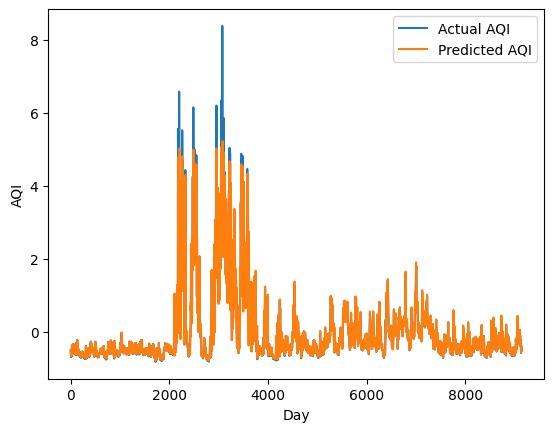

In [28]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [29]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([49.92178391, 47.73194758, 45.18879525, ..., 48.99124973,
       47.94790565, 47.37589409])

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([47.20500183, 44.42499789, 42.03499777, ..., 47.50499926,
       46.9549995 , 49.26000079])

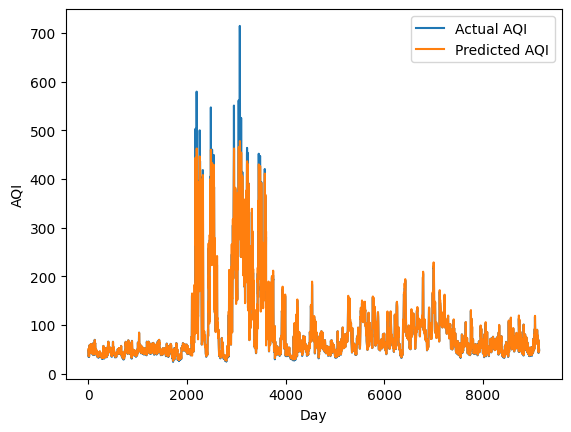

In [31]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [32]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 49.36892587,  54.4907643 ,  60.58272772,  63.40723834,
        62.55565322,  59.51473275,  57.38449512,  56.40345145,
        56.08242181,  55.79900144,  55.54292026,  55.59814433,
        55.35609058,  56.08777156,  57.23537312,  58.11884203,
        58.59677675,  58.98996536,  58.99357063,  58.21921691,
        56.99952794,  55.84436695,  55.12209724,  55.07729533,
        56.9042881 ,  59.40309477,  62.66433899,  63.32183023,
        62.04673827,  62.12345974,  61.40812323,  60.53348409,
        59.78324449,  59.57177287,  58.83808797,  56.83102875,
        53.00544869,  52.03175869,  52.61296681,  52.86975473,
        52.25392533,  51.31314791,  49.85756009,  47.34371508,
        45.82439547,  50.23549566,  74.37479073, 109.55894787,
       119.8422558 ,  97.31753584,  89.22639468,  99.11654531,
       106.3988546 , 112.17718007, 120.11827778, 124.13895145,
       129.80648211, 134.54810371, 145.36813992, 187.17719338,
       258.83982026, 309.53400075, 306.96164846, 266.02

In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 54.81000025,  61.05000096,  63.8150001 ,  62.83000004,
        59.55999985,  57.24499909,  56.25999902,  55.99500084,
        55.73999989,  55.48499894,  55.55499969,  55.31000044,
        56.08500052,  57.30500036,  58.21999969,  58.68999924,
        59.06999912,  59.05999965,  58.24000086,  56.94499942,
        55.73000043,  54.99500045,  54.9899996 ,  56.95499889,
        59.58000102,  62.90000078,  63.57499947,  62.20500091,
        62.19000059,  61.48999988,  60.57999917,  59.80000048,
        59.59000049,  58.85500051,  56.7550006 ,  52.66499938,
        51.66499899,  52.45000077,  52.79000054,  52.110001  ,
        51.07499912,  49.50500003,  46.76000206,  45.16999957,
        50.29500043,  74.72000047, 105.82500014, 117.8250003 ,
       101.56999988,  90.70999992,  97.70999982, 105.13999974,
       110.98500026, 118.17499954, 122.75000064, 127.92499884,
       132.6549995 , 141.62999872, 173.06500429, 231.54500112,
       287.21000146, 298.69499888, 270.18500853, 237.37

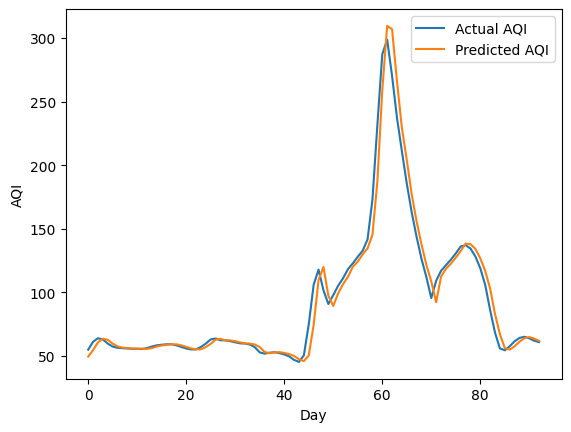

In [34]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [35]:
# Saving the model

torch.save(model.state_dict(), "lstm_model.pt")  # Replace "lstm_model.pt" with your desired filename